In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.style.use('ggplot')

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

/home/asa/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Common Code

In [2]:
# Files supplied by the competition for model training
X_train = pd.read_csv('../../data/dengue_features_train.csv')
y_train = pd.read_csv('../../data/dengue_labels_train.csv', usecols=['total_cases'])

In [7]:
X_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [3]:
# Files supplied by the competition for submission
X_test = pd.read_csv('../../data/dengue_features_test.csv')
y_test = pd.read_csv('../../data/submission_format.csv')

In [5]:
def create_submission_file(pipeline, filename_comment):
    next_file_id = generate_next_submission_fileid()
    X_test_processed = data_preprocess(X_test)
    y_submit_pred = np.rint(pipeline.predict(X_test_processed))
    y_test['total_cases'] = y_submit_pred
    y_test['total_cases'] = y_test['total_cases'].astype(int)
    filename = f'../../data/dengue_submission_{next_file_id}_{filename_comment}.csv'
    y_test.to_csv(filename, index = False)
    
    return y_submit_pred, filename

In [6]:
def generate_next_submission_fileid():
    files_found = []
    for file in os.listdir("../../data"):
        if file.startswith("dengue_submission"):
            files_found.append(file[18:20])
    return f'{int(sorted(files_found).pop()) + 1 :02}'

## Notebook-specific code

Autocorrelate precipitation to total cases and add as a new colums to original dataset

In [43]:
X_train['week_start_date'] = pd.to_datetime(X_train['week_start_date'])
X_test['week_start_date'] = pd.to_datetime(X_test['week_start_date'])

In [67]:
df_train = pd.merge(X_train, y_train, left_index= True, right_index=True)
df_train.set_index('week_start_date', inplace = True)
precip_subset = df_train[df_train['city']=='sj'][['precipitation_amt_mm','total_cases']]
precip_subset.head()

,precipitation_amt_mm,total_cases
week_start_date,,
1990-04-30,12.42,4
1990-05-07,22.82,5
1990-05-14,34.54,4
1990-05-21,15.36,3
1990-05-28,7.52,6


In [68]:
n_offset = 12
for i in range(-1,-n_offset,-1):
    precip_subset[f'prc_{i}'] = precip_subset['precipitation_amt_mm'].shift(i)

In [69]:
precip_subset.head(10)

,precipitation_amt_mm,total_cases,prc_-1,prc_-2,prc_-3,prc_-4,prc_-5,prc_-6,prc_-7,prc_-8,prc_-9,prc_-10,prc_-11
week_start_date,,,,,,,,,,,,,
1990-04-30,12.42,4,22.82,34.54,15.36,7.52,9.58,3.48,151.12,19.32,14.41,22.27,59.17
1990-05-07,22.82,5,34.54,15.36,7.52,9.58,3.48,151.12,19.32,14.41,22.27,59.17,16.48
1990-05-14,34.54,4,15.36,7.52,9.58,3.48,151.12,19.32,14.41,22.27,59.17,16.48,32.66
1990-05-21,15.36,3,7.52,9.58,3.48,151.12,19.32,14.41,22.27,59.17,16.48,32.66,28.80
1990-05-28,7.52,6,9.58,3.48,151.12,19.32,14.41,22.27,59.17,16.48,32.66,28.80,90.75
1990-06-04,9.58,2,3.48,151.12,19.32,14.41,22.27,59.17,16.48,32.66,28.80,90.75,32.40
1990-06-11,3.48,4,151.12,19.32,14.41,22.27,59.17,16.48,32.66,28.80,90.75,32.40,40.94
1990-06-18,151.12,5,19.32,14.41,22.27,59.17,16.48,32.66,28.80,90.75,32.40,40.94,28.86
1990-06-25,19.32,10,14.41,22.27,59.17,16.48,32.66,28.80,90.75,32.40,40.94,28.86,64.56


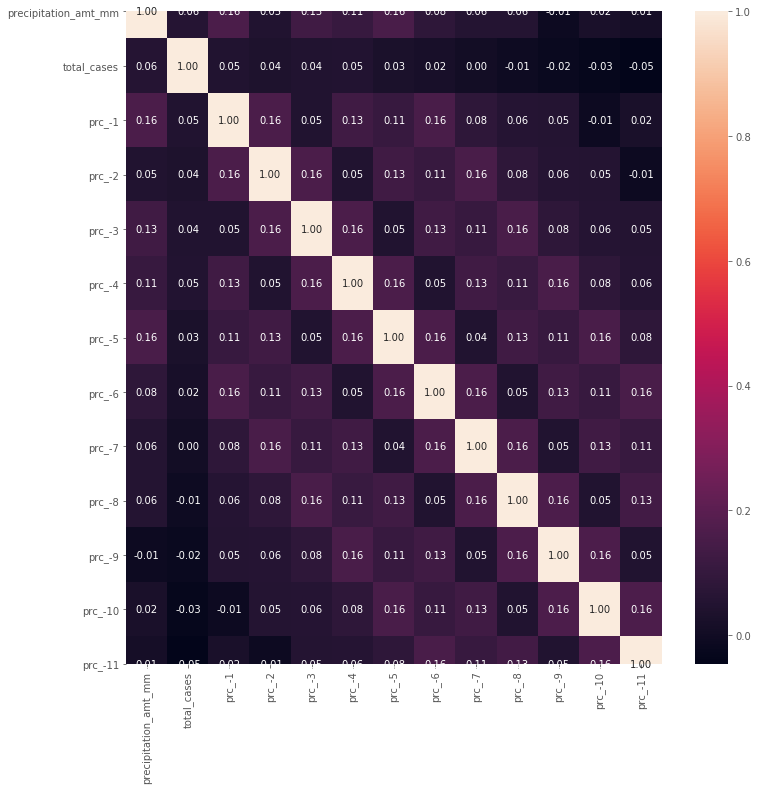

In [70]:
correlation = precip_subset.corr()
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(correlation, annot=True, ax=ax, fmt=".2f")